In [46]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [47]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.inference
import endoutbreakvbd.model
import endoutbreakvbd.utils

importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.inference)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd.utils)
importlib.reload(endoutbreakvbd)

from endoutbreakvbd import eop_analytical, eop_simulation, renewal_model
from endoutbreakvbd.chikungunya import get_parameters
from endoutbreakvbd.inference import (
    _lognormal_params_from_median_percentile_2_5,
    fit_periodic_model,
)
from endoutbreakvbd.utils import month_start_xticks

In [48]:
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]
rng = np.random.default_rng(2)

In [49]:
rep_no_max = 2
rep_no_amplitude = 1
rep_no_min = rep_no_max - 2 * rep_no_amplitude
doy_max = 215


def rep_no_func_doy(doy):
    return np.maximum(
        0.5
        * (
            rep_no_max
            + rep_no_min
            + (rep_no_max - rep_no_min) * np.cos(2 * np.pi * (doy - doy_max) / 365)
        ),
        0,
    )

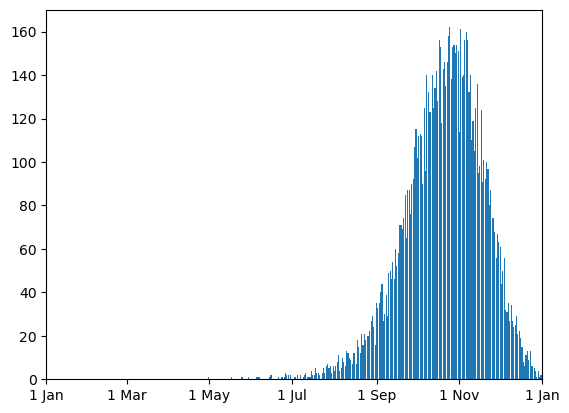

In [50]:
doy_start = 120

found_outbreak = False
tries = 0
while not found_outbreak:
    incidence_vec = renewal_model(
        rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
        t_stop=366,
        gen_time_dist_vec=gen_time_dist_vec,
        rng=rng,
        incidence_init=1,
    )
    if incidence_vec.sum() >= 500:
        found_outbreak = True
    tries += 1
    if tries > 10000:
        raise RuntimeError("Could not simulate outbreak with at least 500 cases.")

fig, ax = plt.subplots()
ax.bar(doy_start + np.arange(len(incidence_vec)), incidence_vec)
ax.set_xlim(1, 366)
month_start_xticks(ax)

In [51]:
idata = fit_periodic_model(
    incidence_vec=incidence_vec,
    gen_time_dist_vec=gen_time_dist_vec,
    doy_start=doy_start,
    priors={
        "rep_no_max": (
            pm.LogNormal,
            _lognormal_params_from_median_percentile_2_5(rep_no_max, 0.1),
        ),
        "rep_no_amplitude": (
            pm.LogNormal,
            _lognormal_params_from_median_percentile_2_5(rep_no_amplitude, 0.1),
        ),
        "doy_max": (
            pm.TruncatedNormal,
            {"mu": doy_max, "sigma": 30, "lower": 1, "upper": 366},
        ),
    },
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rep_no_max, rep_no_amplitude, doy_max]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'rep_no_max'}>,
        <Axes: title={'center': 'rep_no_max'}>],
       [<Axes: title={'center': 'rep_no_amplitude'}>,
        <Axes: title={'center': 'rep_no_amplitude'}>],
       [<Axes: title={'center': 'doy_max'}>,
        <Axes: title={'center': 'doy_max'}>]], dtype=object)

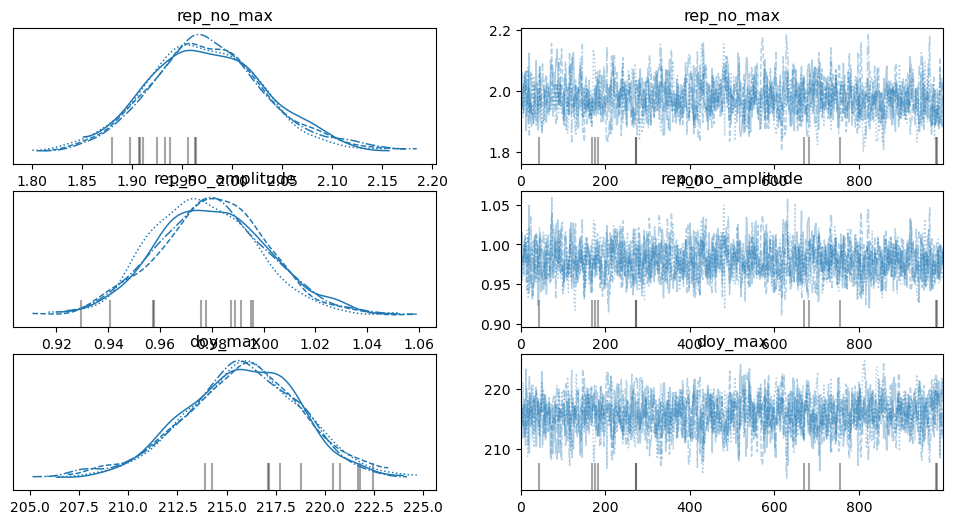

In [52]:
az.plot_trace(idata, var_names=["rep_no_max", "rep_no_amplitude", "doy_max"])